In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

<p> helper functions and classes </p>

In [2]:
def see_data_stored(data_from_customDataFunction):
  x = print('\nFirst iteration of data set: ', next(iter(data_from_customDataFunction)), '\n') # Display text and label.
  y =print('Length of data set: ', len(data_from_customDataFunction), '\n')                  # Print how many items are in the data set
  z = print('Entire data set: ', list(DataLoader(data_from_customDataFunction)), '\n')        # Print entire data set
  return x,y,z

In [3]:
class SeabornFigToGrid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

### Prepare data

<p> LOAD LALONDE DATASET </p>

In [4]:
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
#Combine treatment and control as pandas dataframe
nswre74_pd_df = pd.concat([nswre74_control,nswre74_treated])
#Drop the outcome variable -> as to not bias results
#nswre74_pd_df.drop('re78', axis=1, inplace=True)
#Shuffle data
nswre74_pd_df = shuffle(nswre74_pd_df).reset_index(drop=True)

<P> LOAD SIMULATED DATASET</P>

In [12]:
simulated_dataset = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/simulated_experimental_dataset.csv')
simulated_dataset.drop('Unnamed: 0', axis=1, inplace=True)

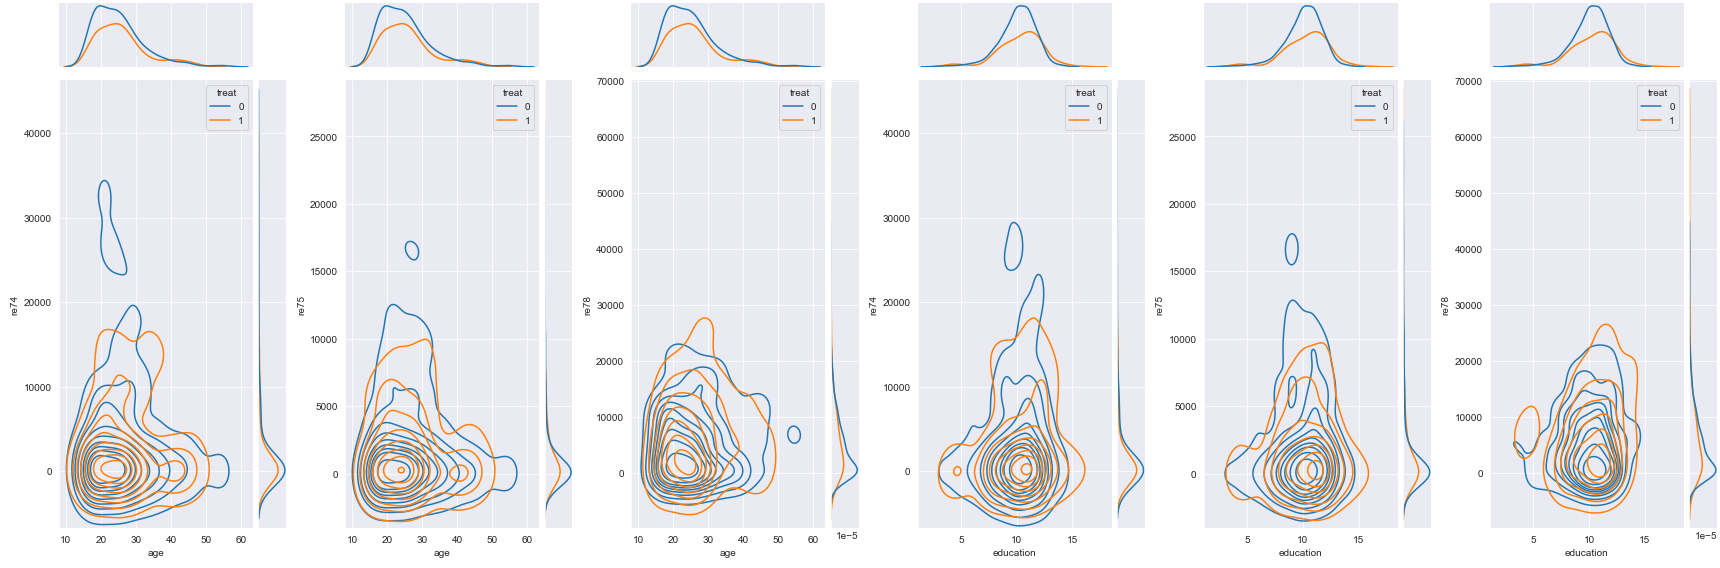

In [822]:
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'

g0 = sns.jointplot(data= nswre74_pd_df,x="age",y="re74", hue= hue, kind=plot_kind)
g1 = sns.jointplot(data= nswre74_pd_df,x="age",y="re75", hue= hue, kind=plot_kind)
g2 = sns.jointplot(data= nswre74_pd_df,x="age",y="re78", hue= hue, kind=plot_kind)
g3 = sns.jointplot(data= nswre74_pd_df,x="education",y="re74", hue= hue, kind=plot_kind)
g4 = sns.jointplot(data= nswre74_pd_df,x="education",y="re75", hue= hue, kind=plot_kind)
g5 = sns.jointplot(data= nswre74_pd_df,x="education",y="re78", hue= hue, kind=plot_kind)


fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1,6)

mg0 = SeabornFigToGrid(g0, fig, gs[0])
mg1 = SeabornFigToGrid(g1, fig, gs[1])
mg2 = SeabornFigToGrid(g2, fig, gs[2])
mg3 = SeabornFigToGrid(g3, fig, gs[3])
mg4 = SeabornFigToGrid(g4, fig, gs[4])
mg5 = SeabornFigToGrid(g5, fig, gs[5])

gs.tight_layout(fig)


<AxesSubplot:xlabel='treat', ylabel='count'>

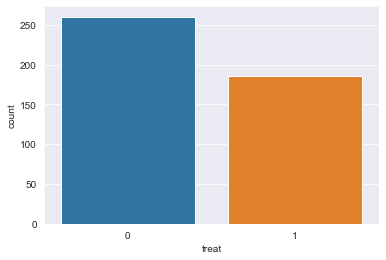

In [823]:
sns.countplot(x = 'treat', data=nswre74_pd_df)

#### Data pre-processing

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Standardize continous variables 
nswre74_pd_df[['age','education','re74','re75','re78']] = sc.fit_transform(nswre74_pd_df[['age','education','re74','re75','re78']])

nsw_final_evaluation = nswre74_pd_df[400:445] # Subset of data for final evaluation 
#nswre74_pd_df = nswre74_pd_df[0:399] # Subset of data for K-fold cross validation 
nswre74_pd_df = nswre74_pd_df

features_df = nswre74_pd_df.drop('treat', axis=1)
target_df = nswre74_pd_df.iloc[:,0]

features_array = np.array(features_df)
target_array = np.array(target_df)

FEATURES = torch.tensor(features_array)
TARGET = torch.tensor(target_array).unsqueeze(1)


In [235]:
simulated_dataset
simulated_dataset = shuffle(simulated_dataset).reset_index(drop=True)

features_df  = simulated_dataset.drop('assignment', axis=1)
target_df = simulated_dataset.drop(['outcome','X0','X1','X2','X3','X4','X5','X6','X7','X8','X9'], axis=1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
simulated_dataset[['outcome','X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']] = sc.fit_transform(simulated_dataset[['outcome','X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']])
# Standardize continous variables 



features_array = np.array(features_df)
target_array = np.array(target_df)

FEATURES = torch.tensor(features_array)
TARGET = torch.tensor(target_array)



tensor([[1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],

#### Custom class for datasets

In [7]:
class CustomDataset:
  def __init__(self,features,target):    # initilise class 
    self.features = features              # import features
    self.target = target               # import targets 
  
  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
  
    features = self.features[idx]
    target = self.target[idx]
    
    return (features, target)
 

####  Construct NN

<p> set hyper parameters </p>

### Model 

In [8]:
# Define neural netowork class 
class threelayerNN(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2,num_hidden_3,num_hidden_4,num_hidden_5):
        super(threelayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.hidden_layer2 =  nn.Linear(num_hidden_2, num_hidden_3) 
        self.hidden_layer3 =  nn.Linear(num_hidden_3, num_hidden_4) 
        self.hidden_layer4 =  nn.Linear(num_hidden_4, num_hidden_5)
        self.hidden_layer5 =  nn.Linear(num_hidden_5, num_classes) 
    
        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        self.batchnorm3 = nn.BatchNorm1d(num_hidden_3)
        self.batchnorm4 = nn.BatchNorm1d(num_hidden_4)
        self.batchnorm5 = nn.BatchNorm1d(num_hidden_5)
    
    # Forward propogation method
    def forward(self, x):
        # input 
        x = self.input_layer(x)
        x = self.relu_activation(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        # first hidden layer
        x = self.hidden_layer1(x)
        x = self.relu_activation(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        # second hidden layer and output
        x = self.hidden_layer2(x)
        x = self.relu_activation(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.hidden_layer3(x)
        x = self.relu_activation(x)
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.hidden_layer4(x)
        x = self.relu_activation(x)
        x = self.batchnorm5(x)
        x = self.dropout(x)
        x = self.hidden_layer5(x)
        x = self.output_activation(x)
        return x


class twoLayerNN(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2):
        super(twoLayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.relu_activation(self.hidden_layer1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





<p> NN helper functions </p>

In [9]:
# Function to reset model weights 
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [10]:
# Function to initialise model weights 
def initialize_weights(m):
    classname = m.__class__.__name__
    # For every linear layer in the mdoel   
    if classname.find('Linear') != -1:
     n = m.in_features
     y = 1.0/np.sqrt(n)
     m.weight.data.uniform_(-y, y)
     m.bias.data.fill_(0)
    

### K-fold cross validation

<p> Initial settings <p>

In [11]:
# Set model hyper parameters 
NUM_FEATURES = FEATURES.shape[1]
NUM_HIDDEN_1 = 500
NUM_HIDDEN_2 = 250
NUM_HIDDEN_3 = 50
NUM_HIDDEN_4 = 25 
NUM_HIDDEN_5 = 12            
NUM_CLASSES = 1
NUM_EPOCHS = 50
BATCH_SIZE = 256

LEARNING_RATE = 0.0001

# training configuration options  
K_FOLDS = 5     
splits = KFold(n_splits=K_FOLDS,shuffle=True,random_state=42)

In [12]:
# Dictionaries to store results  
validation_accuracy_dict = {}      
validation_loss_dict = {}
training_accuracy_dict = {}
training_loss_dict = {}
foldperf = {}
acc_per_epoch = {}
fold_validation_accuracy = {}


In [13]:
# Function to calculate accuracy 
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [14]:
from torchmetrics import Accuracy
from sklearn.metrics import accuracy_score
accuracy = Accuracy()

### Cross validation 1

In [15]:
# set seeds 
torch.manual_seed(1)

In [17]:
kfold = KFold(n_splits= K_FOLDS, shuffle=True)
dataset = CustomDataset(features = FEATURES,target = TARGET)

In [18]:
for fold, (train_ids, test_ids) in enumerate(splits.split(dataset)):
    subsampler = SubsetRandomSampler(test_ids)
    trainloader = DataLoader(dataset,  batch_size=BATCH_SIZE, sampler=subsampler)
    X = pd.DataFrame(trainloader.dataset.target.numpy())
    fold = fold+1
    #print(fold, X)

#pd.DataFrame(trainloader.dataset.target.numpy())

In [23]:
print("==========  start =============")  

for fold, (train_ids, test_ids) in enumerate(splits.split(np.arange(len(dataset)))):
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)
    # Define data loaders for training and testing data in this fold
    
    trainloader = DataLoader(dataset,  batch_size=BATCH_SIZE, sampler=train_subsampler)
    testloader = DataLoader(dataset,batch_size=BATCH_SIZE, sampler=test_subsampler)

    # Instanstiate model 
    #model = threelayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2,num_hidden_3 = NUM_HIDDEN_3,
    #num_hidden_4 = NUM_HIDDEN_4,num_hidden_5 = NUM_HIDDEN_5)
    model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2)
    model.to(device)
    # Reset weights 
    #model.apply(reset_weights)
    model.apply(initialize_weights)
    #Initialise optimiser and loss function 
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    metrics = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    # Run training and validation n epochs  
    for epoch in range(0, NUM_EPOCHS):
        # Training variables 
        running_training_loss = 0
        total_training_samples = 0 
        train_correct = 0
        train_accuracy = 0
        #set model to training mode
        model.train()
        print('==========  Training ==========') 
        for idx, (features,target) in enumerate(trainloader,start = 0):       # Iterate over the DataLoader for training data

            # GET DATA  
            target_tensor = target
            train_features = features.float().to(device)
            train_target = target.float().to(device)
            train_outputs = model(train_features)
      
            # COMPUTE LOSS
            loss = criterion(train_outputs , train_target)
             # ZERO PARAMETER GRADIENTS  
            optimizer.zero_grad()
            loss.backward()
            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # ========== TRAINING LOGGING ========== #

            #calculate training accuracy
            # At the completion of each epoch , store train losses 
            train_prediction = (train_outputs >= 0.5).type(torch.uint8) 
            running_training_loss += loss.item()*train_target.shape[0]
            training_loss  = running_training_loss / len(trainloader.sampler)
            train_correct += (train_prediction == train_target).numpy().sum()

        # STORE AND LOG TRAINING INFORMATION
        train_accuracy = train_correct/len(trainloader.sampler)*100
        training_accuracy_dict[(fold,epoch)] = train_accuracy.item()
        training_loss_dict[(fold,epoch)] = training_loss
        print(f'Fold: {fold}'f' | Epoc: {epoch+1}/{NUM_EPOCHS} 'f' | Training Loss: {training_loss:.4f}'f'| Training accuracy: {train_accuracy:.2f}')

        with torch.no_grad():
            total_validation_samples = 0 
            running_validation_loss = 0
            val_correct = 0
            validation_acc = 0
            model.eval()
            print('==========  Validating ==========') 
            for idx, (features,target) in enumerate(testloader): # Iterate over the test data and generate predictions
                
                val_target_tensor = target
                val_inputs = features.float().to(device)
                val_targets = target.float().to(device) 
                val_outputs = model(val_inputs)

                loss = criterion(val_outputs , val_targets)

                # ========== VALIDATION LOGGING ========== # 

                prediction = (val_outputs >= 0.5).type(torch.uint8) 
                running_validation_loss += loss.item()*val_targets.shape[0]
                validation_loss = running_validation_loss / len(testloader.sampler)
                val_correct += (prediction == val_targets).numpy().sum()

            # STORE AND LOG VALIDATION INFORMATION 
            validation_acc = val_correct/len(testloader.sampler)*100
            validation_accuracy_dict[(fold,epoch)] = validation_acc.item()
            validation_loss_dict[(fold,epoch)] = validation_loss  
            print(f'Fold: {fold}'f' | Epoc: {epoch+1}/{NUM_EPOCHS} | Valid Loss: {validation_loss:.2f}'f'| Validation accuracy: {validation_acc:.2f}')
        #validation_acc = val_correct/len(testloader)
          # * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# Print fold results
torch.save(model.state_dict(), '/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/k_cross_ANN.pt')

validation_accuracy_list = list(validation_accuracy_dict.values())
average_validation_acc = np.sum(validation_accuracy_list)/len(validation_accuracy_list)
training_accuracy_list = list(training_accuracy_dict.values())
average_training_acc = np.sum(training_accuracy_list)/len(training_accuracy_list)

print(f'K-FOLD CROSS VALIDATION RESULTS FOR {K_FOLDS} FOLDS')

print(f'AVG valdiation acc: {average_validation_acc:.2f}| 'f'AVG training acc: {average_training_acc:.2f}')


==========  start =============
==========  Training ==========
Fold: 0 | Epoc: 1/50  | Training Loss: 0.7698| Training accuracy: 49.16
==========  Validating ==========
Fold: 0 | Epoc: 1/50 | Valid Loss: 0.76| Validation accuracy: 53.93
==========  Training ==========
Fold: 0 | Epoc: 2/50  | Training Loss: 0.7569| Training accuracy: 59.27
==========  Validating ==========
Fold: 0 | Epoc: 2/50 | Valid Loss: 0.76| Validation accuracy: 56.18
==========  Training ==========
Fold: 0 | Epoc: 3/50  | Training Loss: 0.7509| Training accuracy: 60.39
==========  Validating ==========
Fold: 0 | Epoc: 3/50 | Valid Loss: 0.77| Validation accuracy: 50.56
==========  Training ==========
Fold: 0 | Epoc: 4/50  | Training Loss: 0.7429| Training accuracy: 62.36
==========  Validating ==========
Fold: 0 | Epoc: 4/50 | Valid Loss: 0.77| Validation accuracy: 48.31
==========  Training ==========
Fold: 0 | Epoc: 5/50  | Training Loss: 0.7401| Training accuracy: 64.04
==========  Validating ==========
Fold: 

In [22]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
input_layer.weight 	 torch.Size([500, 9])
input_layer.bias 	 torch.Size([500])
hidden_layer1.weight 	 torch.Size([250, 500])
hidden_layer1.bias 	 torch.Size([250])
out_layer.weight 	 torch.Size([1, 250])
out_layer.bias 	 torch.Size([1])
batchnorm1.weight 	 torch.Size([500])
batchnorm1.bias 	 torch.Size([500])
batchnorm1.running_mean 	 torch.Size([500])
batchnorm1.running_var 	 torch.Size([500])
batchnorm1.num_batches_tracked 	 torch.Size([])
batchnorm2.weight 	 torch.Size([250])
batchnorm2.bias 	 torch.Size([250])
batchnorm2.running_mean 	 torch.Size([250])
batchnorm2.running_var 	 torch.Size([250])
batchnorm2.num_batches_tracked 	 torch.Size([])
Optimizer's state_dict:
state 	 {0: {'step': tensor(100.), 'exp_avg': tensor([[ 1.7924e-05,  1.3503e-05, -1.3024e-05,  ...,  1.2767e-05,
         -5.8422e-05,  3.5069e-05],
        [-3.9424e-04,  2.0197e-04, -4.5311e-05,  ...,  1.8906e-04,
          1.1811e-04,  5.3802e-07],
        [ 3.1654e-04, -4.8001e-05,  1.2536e-04,  

In [966]:
validation_acc = list(validation_accuracy_dict.values())
average_validation_acc = np.sum(validation_acc)/len(validation_acc)
training_acc = list(training_accuracy_dict.values())
average_validation_acc = np.sum(training_acc)/len(training_acc)

### Plot training summary 

In [967]:
validation_accurary_list = list(validation_accuracy_dict.values())
validation_loss_list = list(validation_loss_dict.values())
training_accuracy_list = list(training_accuracy_dict.values())
training_loss_list = list(training_loss_dict.values())

In [968]:
np.sum(training_acc)

16983.988764044945

<function matplotlib.pyplot.show(close=None, block=None)>

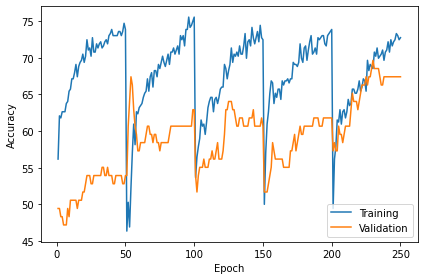

In [969]:
# Plot accuracy for training and validation 
epochs_train = len(training_accuracy_list)
epochs_val = len(validation_accurary_list)

plt.plot(np.arange(1, epochs_train+1),training_accuracy_list, label='Training')
plt.plot(np.arange(1, epochs_val+1),validation_accurary_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

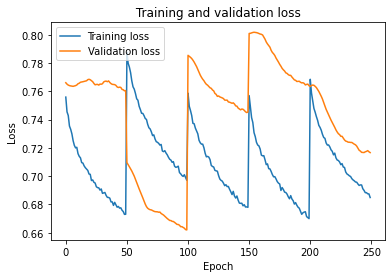

In [970]:
# Plot training and validation losses 
plt.plot(training_loss_list, label='Training loss')
plt.plot(validation_loss_list, label='Validation loss')
plt.title(' Training and validation loss ')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show


<AxesSubplot:>

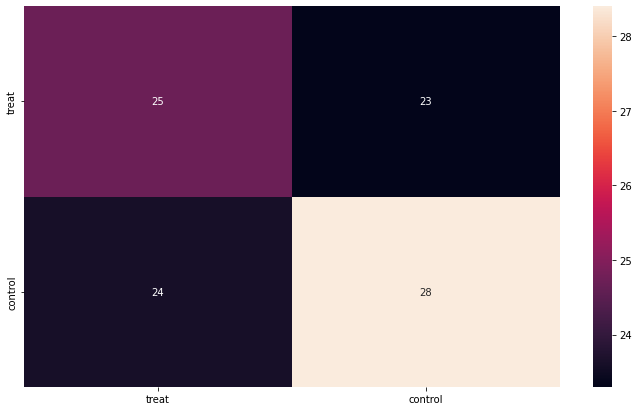

In [940]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

dataset = CustomDataset(features = FEATURES,target = TARGET)

trainloader = DataLoader(dataset,  batch_size=100)
#model = threelayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2,num_hidden_3 = NUM_HIDDEN_3)
model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2)
model.apply(initialize_weights)
# iterate over test data
for idx,(features,target) in enumerate(trainloader,start = 0):

        features = features.float().to(device)
        target = target.float().to(device)
       
        output = model(features) # Feed Network

        outputs = ((output >= 0.5).type(torch.uint8)).numpy()
        y_pred.extend(outputs) # Save Prediction
        
        target = target.numpy()
        y_true.extend(target) # Save Truth

# constant for classes
classes = ('treat', 'control')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in classes],columns = [i for i in classes])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
                                              

### Cross validation 2

<p> Plot loss and accuracy </p>

### Validating model 

In [104]:
# Load hold out data for a quick yesy

features_validation = nsw_final_evaluation.drop('treat', axis=1)
target_validation = nsw_final_evaluation.iloc[:,0]

features_validation_array = np.array(features_validation)
target_validation_array = np.array(target_validation)

FEATURES_VALIDATION = torch.tensor(features_validation_array)
TARGET_VALIDATION = torch.tensor(target_validation_array).unsqueeze(1)

validation_loader = CustomDataset(features = FEATURES_VALIDATION,target = TARGET_VALIDATION)
validation_loader = DataLoader(dataset=validation_loader, batch_size=BATCH_SIZE,shuffle=True)


In [106]:

model = threelayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2,num_hidden_3 = NUM_HIDDEN_3)

model.apply(initialize_weights)

y_pred = []
y_true = []

for idx,(features,target) in enumerate(validation_loader,start = 0):

        features = features.float().to(device)
        target = target.float().to(device)
       
        output = model(features) # Feed Network
        pred = (torch.round(torch.sigmoid(output))).detach().numpy()

        y_pred.extend(pred) # Save Prediction
        
        target = target.numpy()
        y_true.extend(target) # Save Truth

      

<AxesSubplot:>

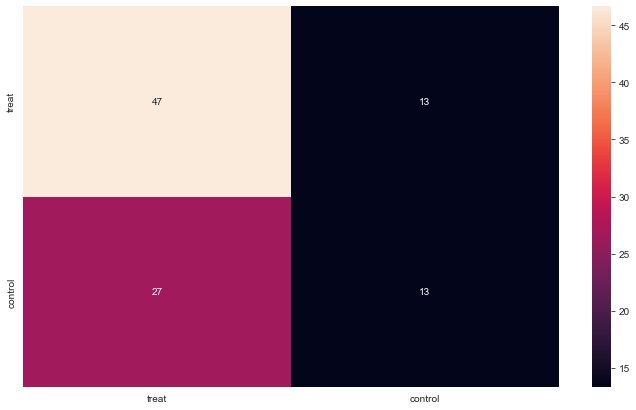

In [107]:
classes = ('treat', 'control')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in classes],columns = [i for i in classes])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)